In [1]:
pip install -qq scikit-learn==1.6.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
islp 0.3.20 requires pandas<=1.9,>=0.20, but you have pandas 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import os 
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

## UTILS

In [3]:
import os
import psutil
import matplotlib.pyplot as plt
import seaborn as sns

def memory_usage():
    """
    Returns the current memory usage of the process in MB.
    """
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 * 1024)  # Convert bytes to megabytes
    return f"Memory Usage: {mem:.2f} MB"


def numerical_distrib_analysis(data, numerical_features):
    """
    Analyzes the distribution of numerical features using histograms and boxplots.

    :param data: Pandas DataFrame containing the dataset
    :param numerical_features: List of numerical column names
    """
    for feature in numerical_features:
        plt.figure(figsize=(12, 5))

        # Histogram with KDE curve
        plt.subplot(1, 2, 1)
        sns.histplot(data[feature], kde=True, bins=30)
        plt.title(f"Histogram of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")

        # Boxplot to detect outliers
        plt.subplot(1, 2, 2)
        sns.boxplot(x=data[feature])
        plt.title(f"Boxplot of {feature}")

        plt.tight_layout()
        plt.show()

        # Additional statistics
        print(f"\nStatistics for {feature}:")
        print(f"Skewness: {data[feature].skew():.2f}")
        print(f"Missing Values: {data[feature].isnull().sum()}")


def categorical_distrib_analysis(data, categorical_features, top_n=10):
    """
    Analyzes and visualizes the distribution of categorical features.

    :param data: Pandas DataFrame containing the dataset
    :param categorical_features: List of categorical column names
    :param top_n: Max number of top categories to display for high-cardinality features
    """
    for feature in categorical_features:
        plt.figure(figsize=(10, 6))

        unique_count = data[feature].nunique()

        if unique_count > top_n:
            # Show only the top_n most frequent categories
            top_categories = data[feature].value_counts().nlargest(top_n)
            sns.barplot(x=top_categories.index, y=top_categories.values, palette="pastel")
            plt.title(f"Top {top_n} Categories of {feature}")
        else:
            # Show all categories
            sns.countplot(x=data[feature], order=data[feature].value_counts().index, palette="pastel")
            plt.title(f"Distribution of {feature}")

        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()

        # Print stats
        print(f"Feature: {feature}")
        print(f"Number of Unique Values: {unique_count}")
        print(f"Missing Values: {data[feature].isnull().sum()}\n")


def numerical_correlation_analysis(data, numerical_features, target):
    """
    Analyzes and visualizes relationships between numerical features and the target.

    :param data: Pandas DataFrame containing the dataset
    :param numerical_features: List of numerical column names
    :param target: Name of the target variable
    """
    for feature in numerical_features:
        if feature != target:
            # Scatter plot: feature vs target
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=data[feature], y=data[target], alpha=0.5)
            plt.title(f"{feature} vs {target}")
            plt.xlabel(feature)
            plt.ylabel(target)
            plt.show()

    # Correlation matrix
    correlation_matrix = data[numerical_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()


def categorical_correlation_analysis(data, categorical_features, target, high_cardinality_threshold=10):
    """
    Visualizes categorical features against the target using boxplots.

    :param data: Pandas DataFrame containing the dataset
    :param categorical_features: List of categorical column names
    :param target: Name of the target variable
    :param high_cardinality_threshold: Max number of unique values allowed for plotting
    """
    for feature in categorical_features:
        if data[feature].nunique() <= high_cardinality_threshold:
            # Boxplot: target distribution per category
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=data[feature], y=data[target], palette='husl')
            plt.title(f"{feature} vs {target}")
            plt.xlabel(feature)
            plt.ylabel(target)
            plt.xticks(rotation=45)
            plt.show()
        else:
            print(f"Skipping {feature}: too many unique values ({data[feature].nunique()})\n")


## EDA

### Overview of the Data

In [28]:
original_df = pd.read_csv("podcast_dataset.csv")
train_df = pd.read_csv('train.csv', index_col='id')
test_df = pd.read_csv('test.csv', index_col='id')


train_df = pd.concat([train_df, original_df], axis=0, ignore_index=True)
train_df.drop_duplicates()

# Drop index columns
# train_df = train_df.drop(columns=['id'])
# test_df = test_df.drop(columns=['id'])

sample_submission = pd.read_csv('sample_submission.csv')

print("\nData Info:")
train_df.info()

print("\nNumerical Features Summary:")
display(train_df.describe())

print("\nFirst 10 rows of Dataset:")
train_df.head(10)


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802500 entries, 0 to 802499
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 802500 non-null  object 
 1   Episode_Title                802500 non-null  object 
 2   Episode_Length_minutes       710161 non-null  float64
 3   Genre                        802500 non-null  object 
 4   Host_Popularity_percentage   802500 non-null  float64
 5   Publication_Day              802500 non-null  object 
 6   Publication_Time             802500 non-null  object 
 7   Guest_Popularity_percentage  651212 non-null  float64
 8   Number_of_Ads                802499 non-null  float64
 9   Episode_Sentiment            802500 non-null  object 
 10  Listening_Time_minutes       797105 non-null  float64
dtypes: float64(5), object(6)
memory usage: 67.3+ MB

Numerical Features Summary:


,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,710161.000000,802500.000000,651212.000000,802499.000000,797105.000000
mean,64.394865,59.879792,52.078083,1.358610,45.444668
std,32.983341,22.891991,28.488536,1.149546,27.140915
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.670000,39.460000,28.070000,0.000000,23.184220
50%,63.740000,60.060000,53.320000,1.000000,43.392270
75%,93.980000,79.560000,76.480000,2.000000,64.814620
max,325.240000,119.460000,119.910000,103.910000,119.970000



First 10 rows of Dataset:


,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
5,Fitness First,Episode 19,26.54,Health,48.96,Saturday,Afternoon,NaN,3.0,Positive,22.77047
6,Criminal Minds,Episode 47,69.83,True Crime,35.82,Sunday,Night,39.02,0.0,Neutral,64.75024
7,News Roundup,Episode 44,48.52,News,44.99,Thursday,Night,20.12,0.0,Positive,22.37517
8,Daily Digest,Episode 32,105.87,News,69.81,Monday,Evening,NaN,2.0,Neutral,68.00124
9,Music Matters,Episode 81,NaN,Music,82.18,Thursday,Night,59.72,3.0,Neutral,45.94761


### Numerical features distrib Analysis

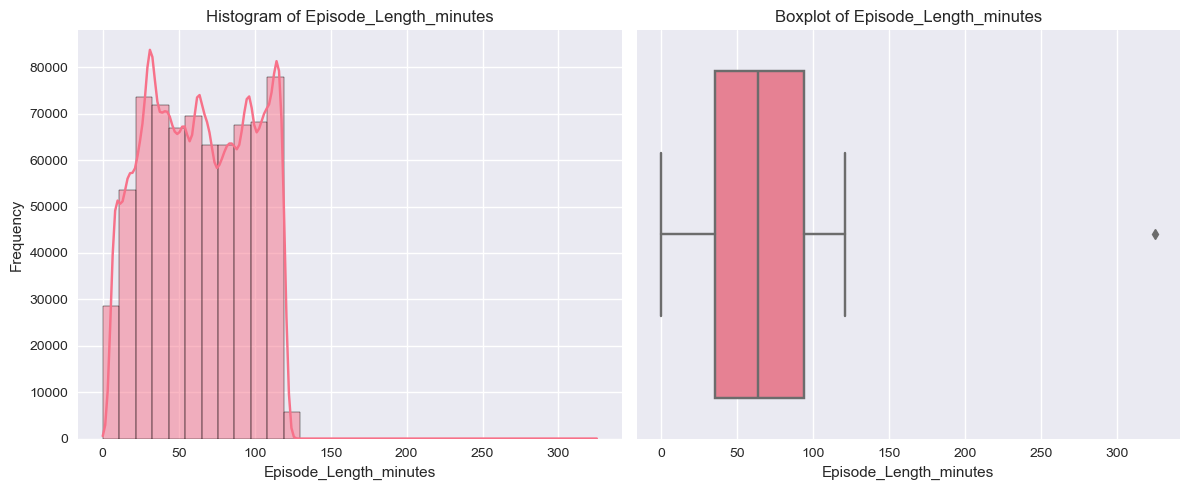


Statistics for Episode_Length_minutes:
Skewness: -0.00
Missing Values: 92339


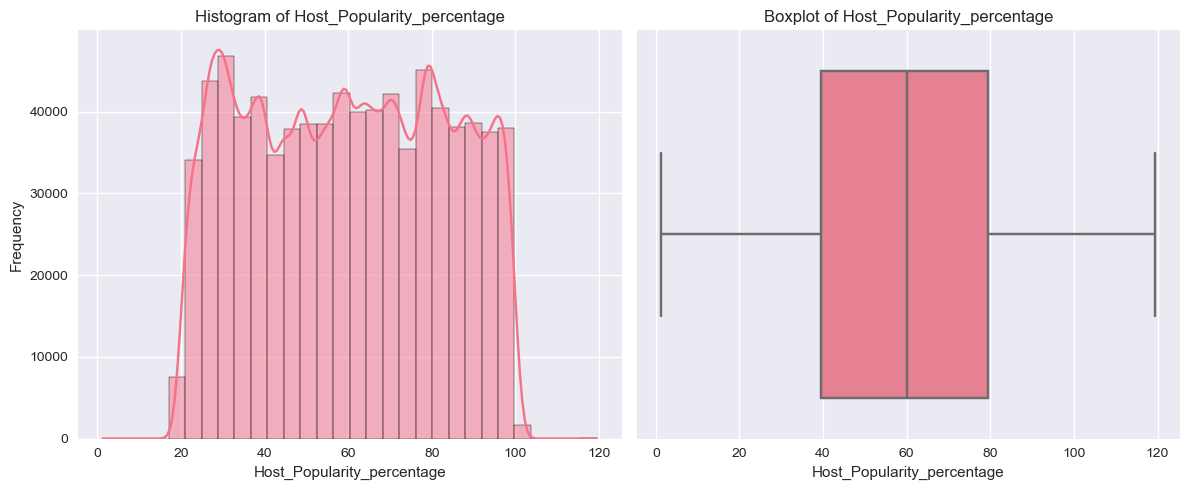


Statistics for Host_Popularity_percentage:
Skewness: 0.00
Missing Values: 0


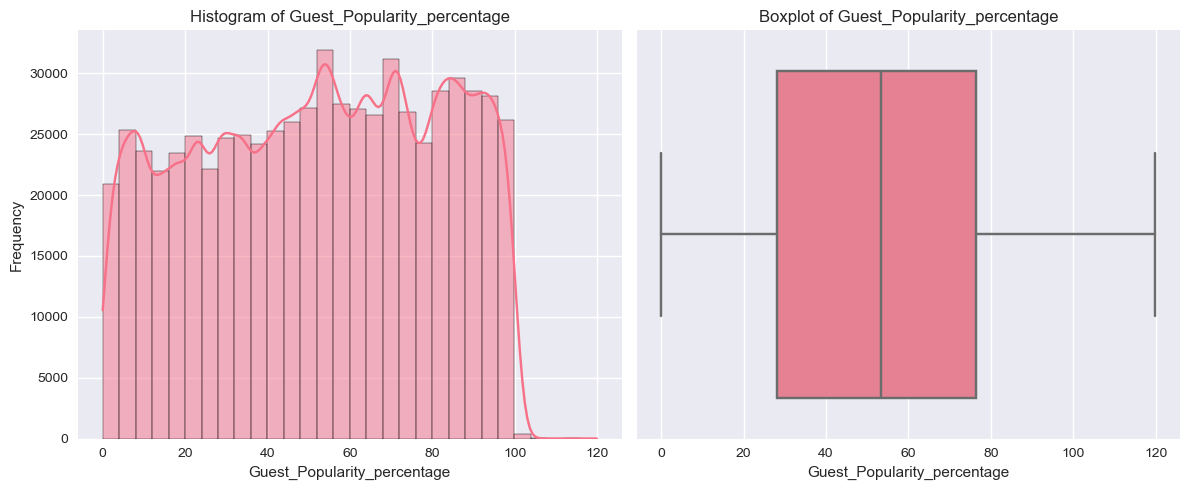


Statistics for Guest_Popularity_percentage:
Skewness: -0.10
Missing Values: 151288


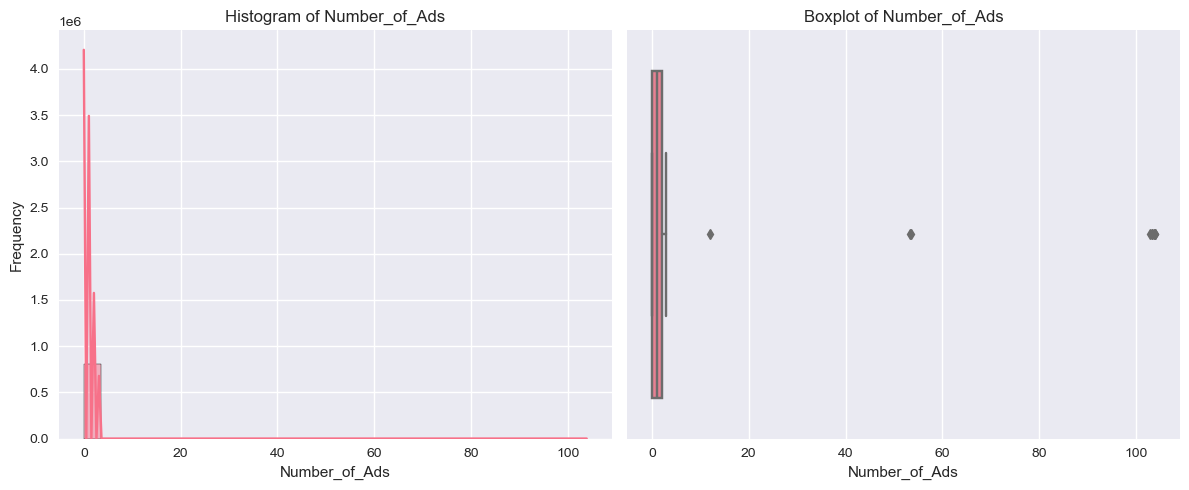


Statistics for Number_of_Ads:
Skewness: 5.66
Missing Values: 1


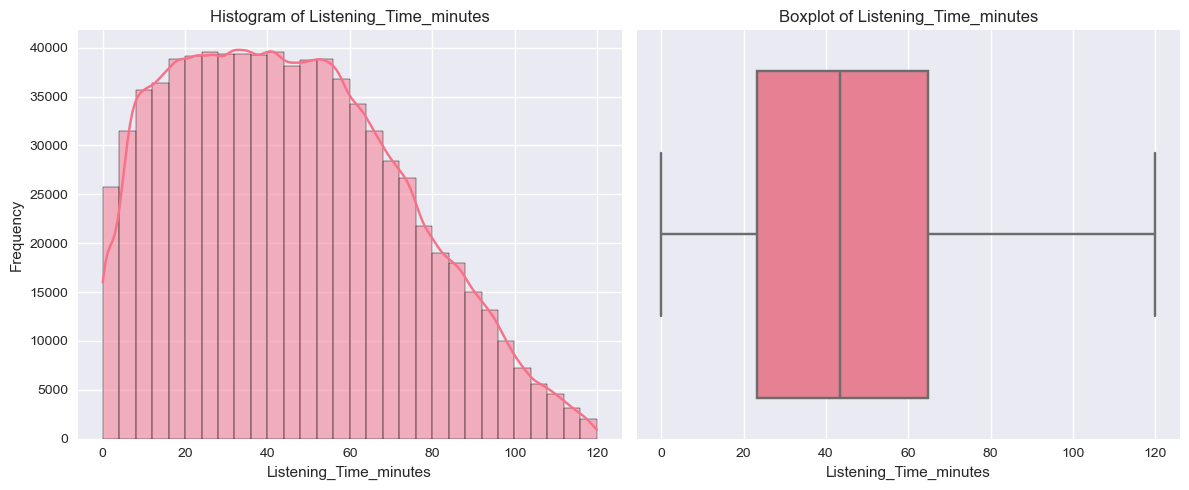


Statistics for Listening_Time_minutes:
Skewness: 0.35
Missing Values: 5395


In [11]:
# Analysing distributions of numerical features
numerical_features = [
    'Episode_Length_minutes', 
    'Host_Popularity_percentage',
    'Guest_Popularity_percentage', 
    'Number_of_Ads',
    'Listening_Time_minutes',
]

numerical_distrib_analysis(train_df, numerical_features)


### Categorial features distrib analysis

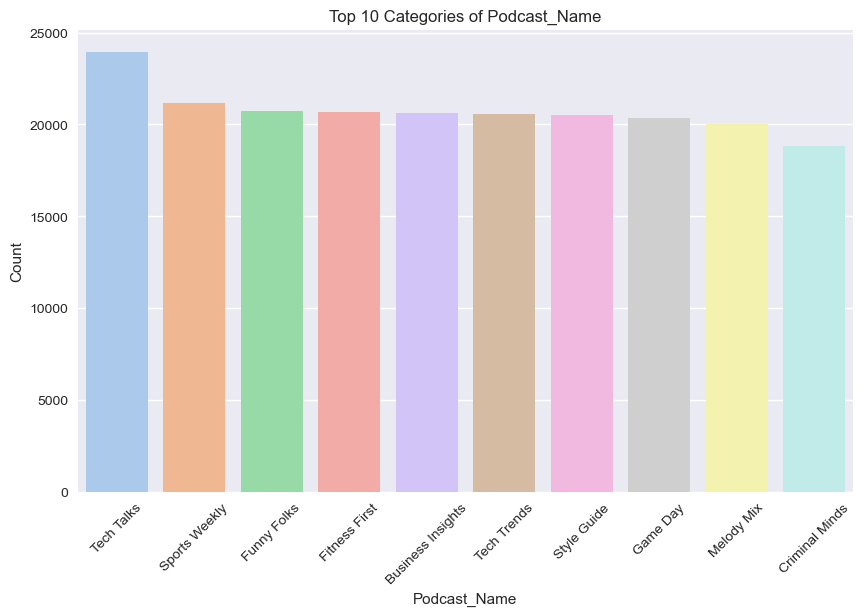

Feature: Podcast_Name
Number of Unique Values: 48
Missing Values: 0



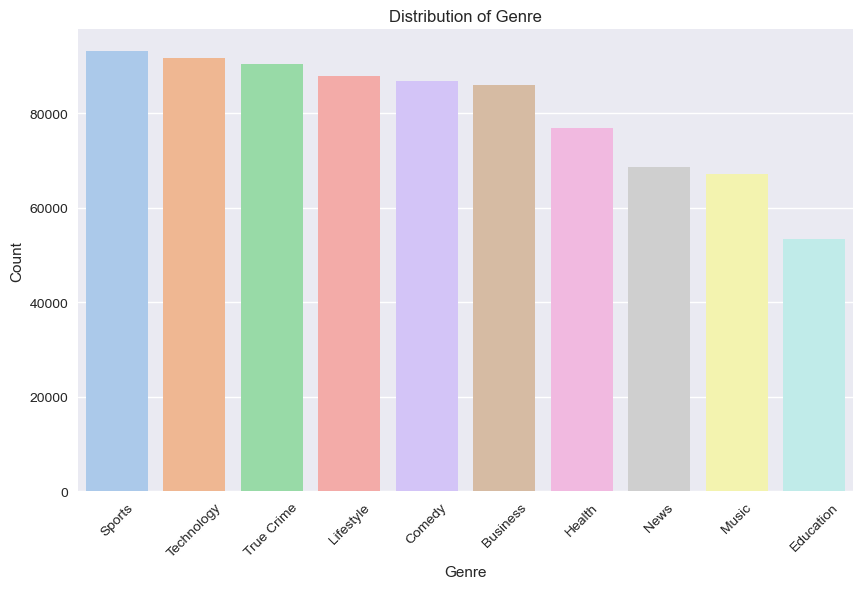

Feature: Genre
Number of Unique Values: 10
Missing Values: 0



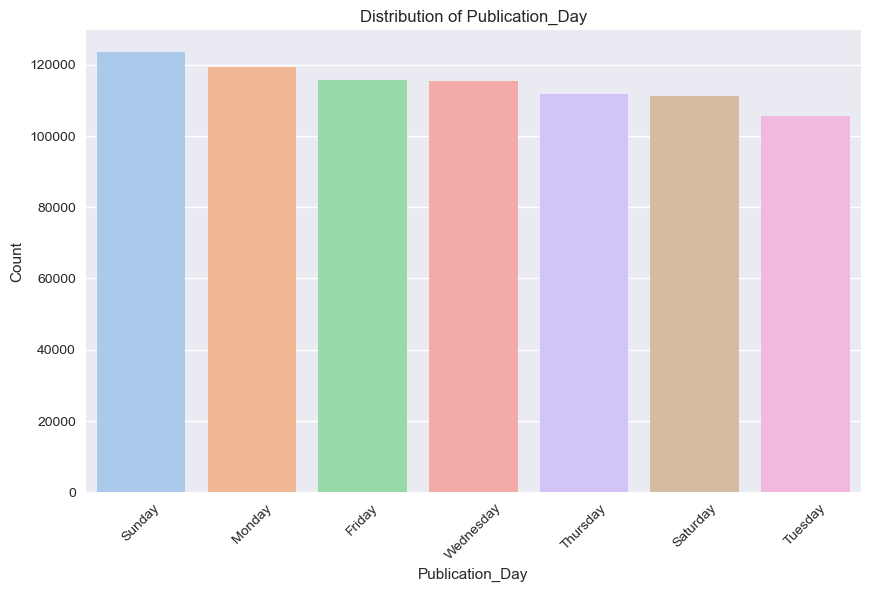

Feature: Publication_Day
Number of Unique Values: 7
Missing Values: 0



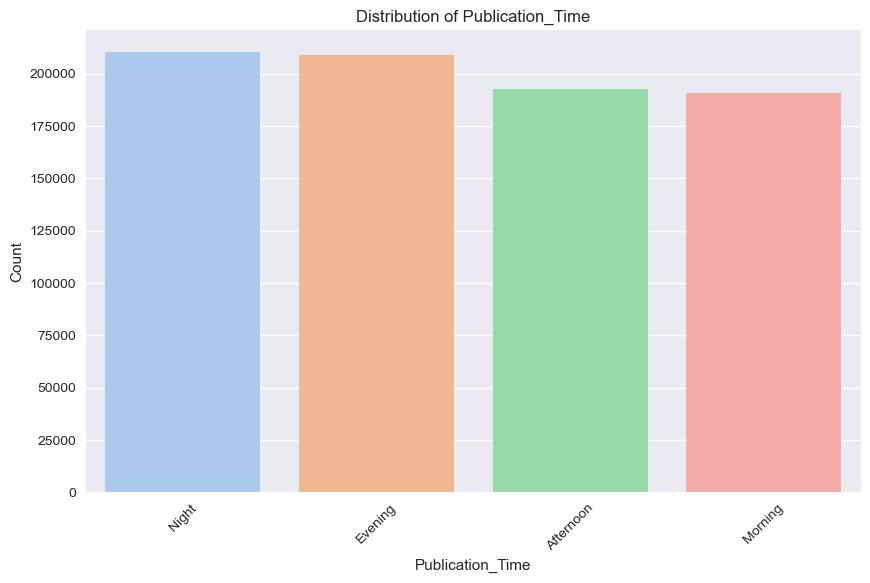

Feature: Publication_Time
Number of Unique Values: 4
Missing Values: 0



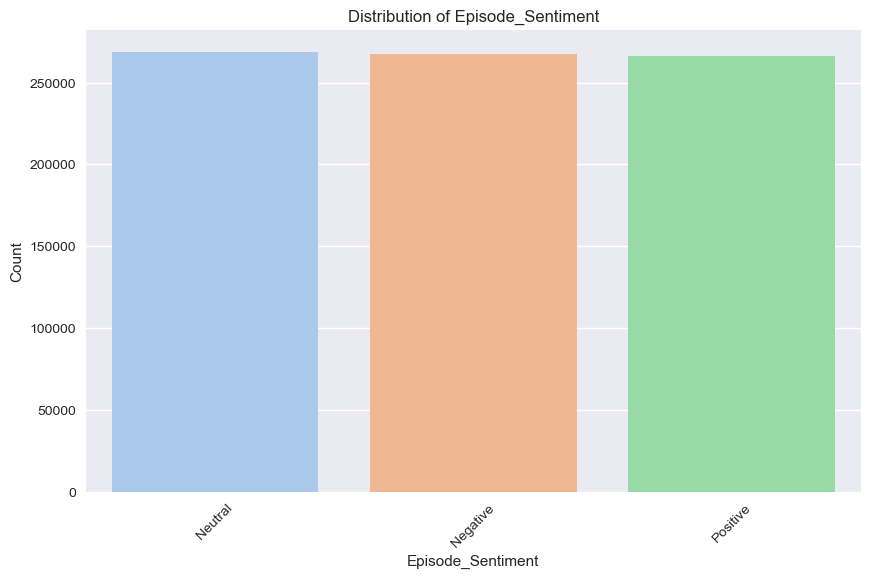

Feature: Episode_Sentiment
Number of Unique Values: 3
Missing Values: 0



In [12]:
categorical_features = [
    'Podcast_Name', 
    'Genre', 
    'Publication_Day',
    'Publication_Time', 
    'Episode_Sentiment'
]

categorical_distrib_analysis(train_df, categorical_features)

### Numerical features correlation analysis 

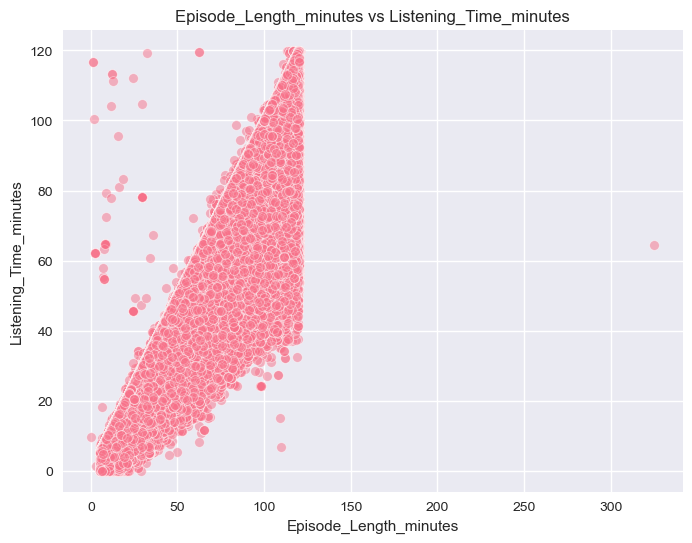

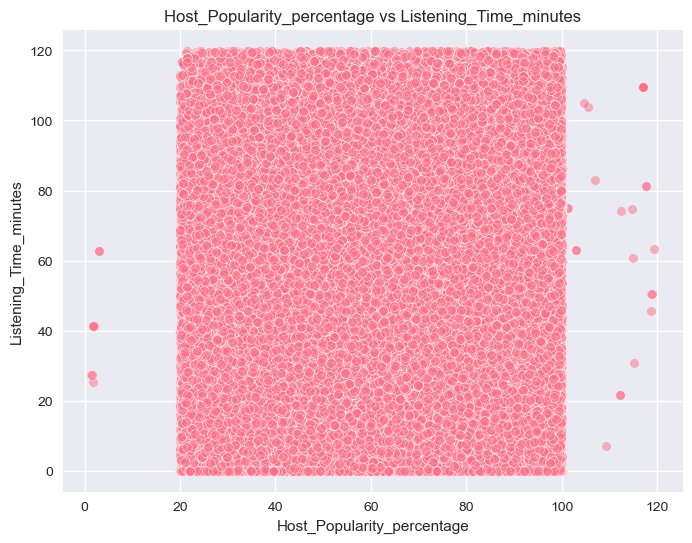

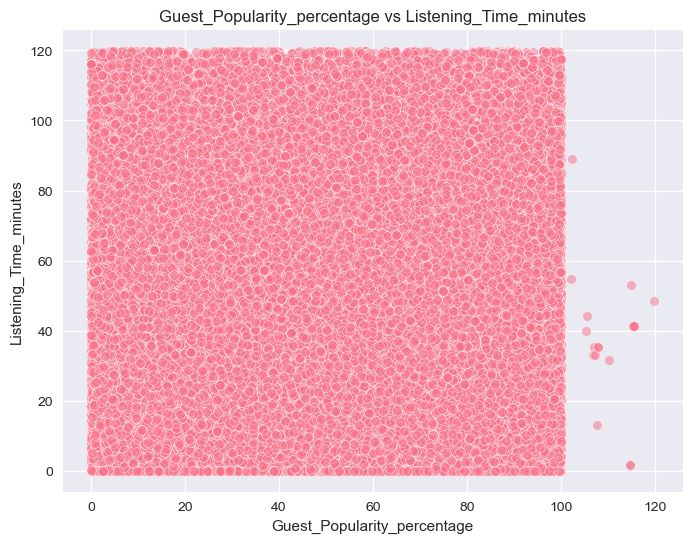

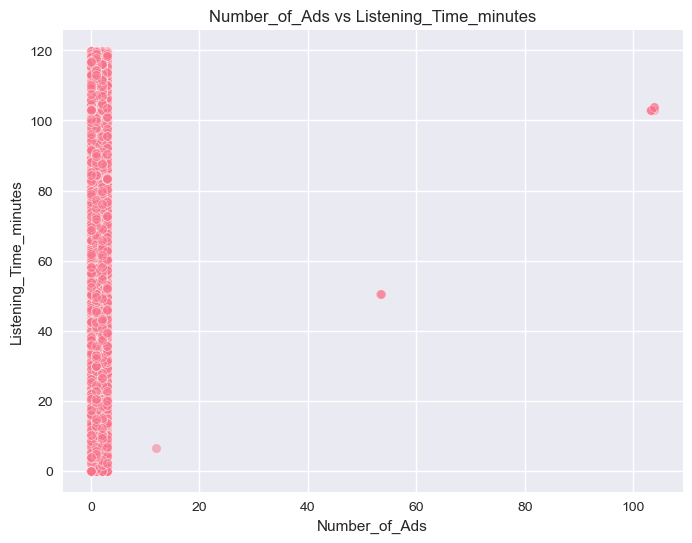

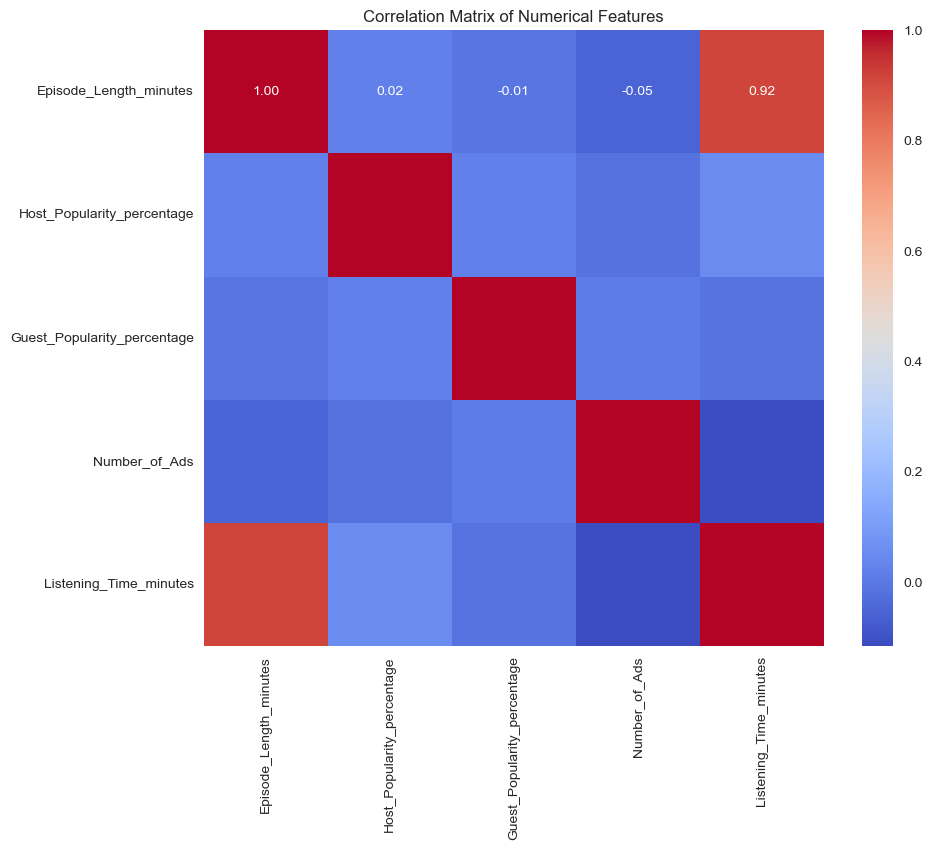

In [13]:
numerical_correlation_analysis(train_df, numerical_features, "Listening_Time_minutes")

### Categorial features correlation analysis

Skipping Podcast_Name: too many unique values (48)



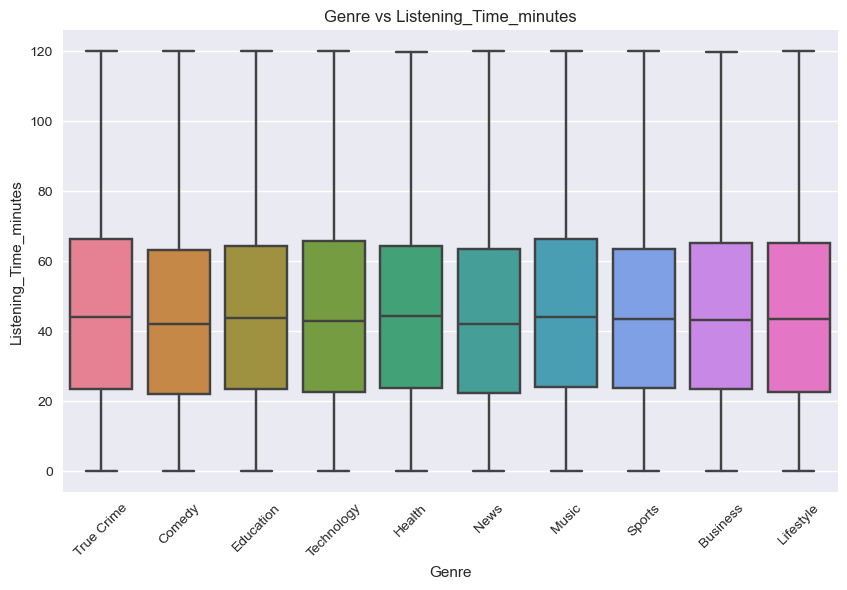

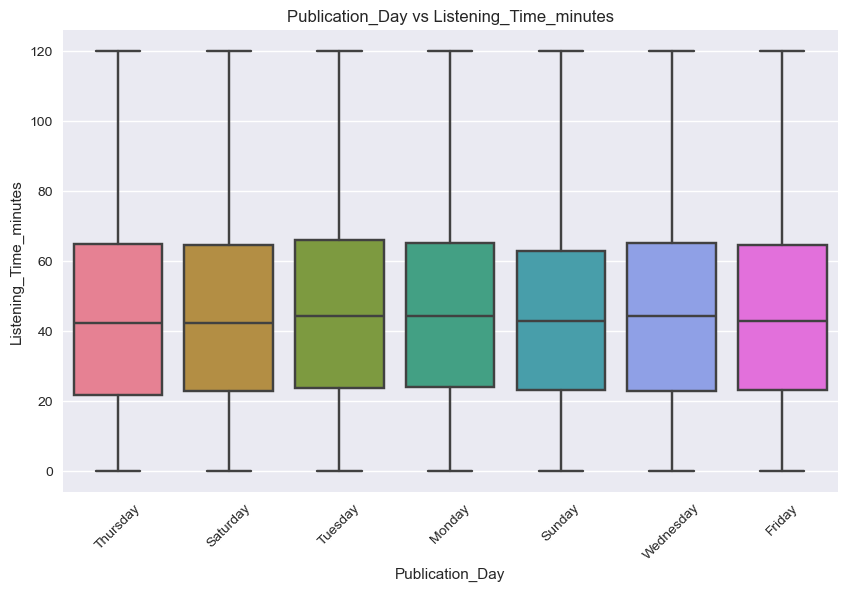

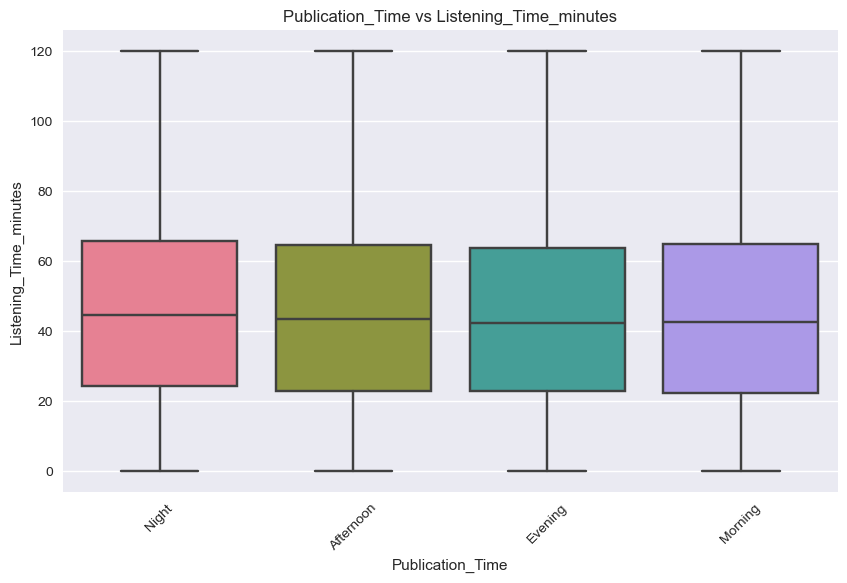

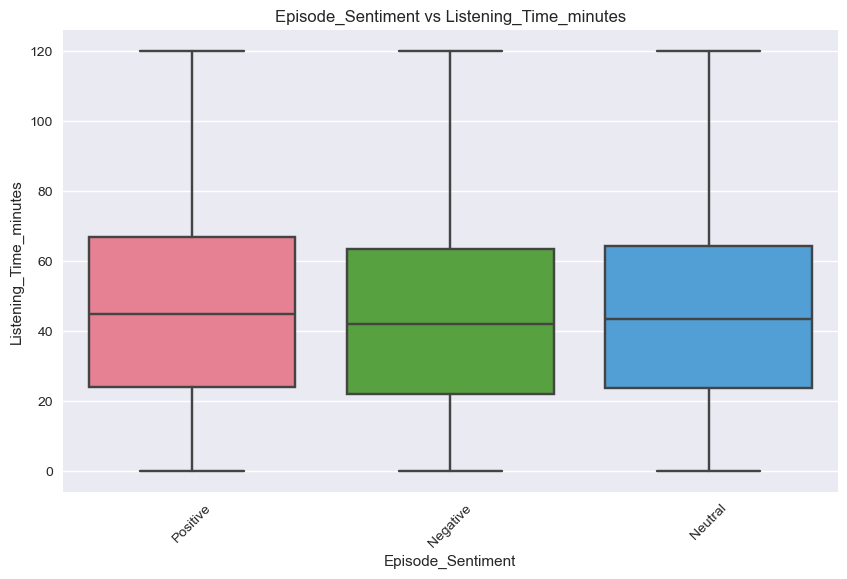

In [14]:
categorical_correlation_analysis(train_df, categorical_features, 'Listening_Time_minutes')

## Preprocessing 

### Managing null values 

In [15]:
print("Missing Values per Column:")
print(train_df.isnull().sum())

print("Missing Values per Column:")
print(test_df.isnull().sum())

Missing Values per Column:
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          92339
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    151288
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes           5395
dtype: int64
Missing Values per Column:
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64


In [16]:
test_df.isna().sum()

Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

In [17]:
# Replacing null values by median
train_df['Episode_Length_minutes'].fillna(train_df['Episode_Length_minutes'].median(), inplace=True)
test_df['Episode_Length_minutes'].fillna(train_df['Episode_Length_minutes'].median(), inplace=True)


# Null values could mean no guest 
train_df['Guest_Popularity_percentage'].fillna(train_df['Guest_Popularity_percentage'].median(), inplace=True)
train_df.dropna(inplace=True)

test_df['Guest_Popularity_percentage'].fillna(test_df['Guest_Popularity_percentage'].median(), inplace=True)

# Deleting outliers 
train_df = train_df[train_df['Number_of_Ads']<10]


### Encoding categorical variables

In [18]:
from sklearn.preprocessing import LabelEncoder

# Encoder for categorical data
label_encoders = {col: LabelEncoder() for col in categorical_features}

# Apply LabelEncoder to each categorical column
for col in categorical_features:
    train_df[col] = label_encoders[col].fit_transform(train_df[col])
    test_df[col] = label_encoders[col].transform(test_df[col])

    # Converting to category type 
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')


In [19]:
train_df.head(10)

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,34,Episode 98,63.74,9,74.81,4,3,53.32,0.0,2,31.41998
1,24,Episode 26,119.80,1,66.95,2,0,75.95,2.0,0,88.01241
2,40,Episode 16,73.90,2,69.97,5,1,8.97,0.0,0,44.92531
3,10,Episode 45,67.17,8,57.22,1,2,78.70,2.0,2,46.27824
4,31,Episode 86,110.51,3,80.07,1,0,58.68,3.0,1,75.61031
5,14,Episode 19,26.54,3,48.96,2,0,53.32,3.0,2,22.77047
6,6,Episode 47,69.83,9,35.82,3,3,39.02,0.0,1,64.75024
7,35,Episode 44,48.52,6,44.99,4,3,20.12,0.0,2,22.37517
8,8,Episode 32,105.87,6,69.81,1,1,53.32,2.0,1,68.00124
9,33,Episode 81,63.74,5,82.18,4,3,59.72,3.0,1,45.94761


### Feature Engineering

In [20]:
import gc
gc.collect()

56564

In [21]:
# creating most relevant feature 
train_df['Episode_Num'] = train_df['Episode_Title'].str[8:].astype('category')
test_df['Episode_Num'] = test_df['Episode_Title'].str[8:].astype('category')

train_df = train_df.drop(columns=['Episode_Title'])
test_df = test_df.drop(columns=['Episode_Title'])

In [22]:
train_df['Podcast_Name'].nunique()

48

In [23]:
from tqdm import tqdm
from itertools import combinations

columns_to_encode = ['Episode_Length_minutes', 
                     'Episode_Num', 
                     'Host_Popularity_percentage', 
                     'Number_of_Ads', 
                     'Episode_Sentiment', 
                     'Publication_Day', 
                     'Publication_Time',
                     'Genre',
                     'Guest_Popularity_percentage']



pair_size = [2, 3, 4]

for r in pair_size: 
    combinations_list = list(combinations(columns_to_encode,r))
    batch_size = 20
    
    for i in range(0, len(combinations_list), batch_size):
        batch = combinations_list[i:i+batch_size]
        for cols in tqdm(batch):
            new_col_name = '_'.join(cols)

            train_df[new_col_name] = train_df[list(cols)].astype(str).agg('_'.join, axis=1) 
            train_df[new_col_name] = train_df[new_col_name].astype('category')

            test_df[new_col_name] = test_df[list(cols)].astype(str).agg('_'.join, axis=1) 
            test_df[new_col_name] = test_df[new_col_name].astype('category')
        gc.collect()
        print(f"Memory usage: {train_df.memory_usage(deep=True).sum() / (1024*1024):.2f} MB")
        print(f"Total number of columns: {len(train_df.columns)}")
        

100%|███████████████████████████████████████████| 20/20 [00:35<00:00,  1.80s/it]


Memory usage: 376.50 MB
Total number of columns: 31


100%|███████████████████████████████████████████| 16/16 [00:26<00:00,  1.68s/it]


Memory usage: 480.35 MB
Total number of columns: 47


100%|███████████████████████████████████████████| 20/20 [00:48<00:00,  2.43s/it]


Memory usage: 1492.47 MB
Total number of columns: 67


100%|███████████████████████████████████████████| 20/20 [00:45<00:00,  2.27s/it]


Memory usage: 2291.21 MB
Total number of columns: 87


100%|███████████████████████████████████████████| 20/20 [00:41<00:00,  2.08s/it]


Memory usage: 2822.05 MB
Total number of columns: 107


100%|███████████████████████████████████████████| 20/20 [00:38<00:00,  1.94s/it]


Memory usage: 3189.96 MB
Total number of columns: 127


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.99s/it]


Memory usage: 3277.98 MB
Total number of columns: 131


100%|███████████████████████████████████████████| 20/20 [00:54<00:00,  2.74s/it]


Memory usage: 4631.08 MB
Total number of columns: 151


100%|███████████████████████████████████████████| 20/20 [00:55<00:00,  2.80s/it]


Memory usage: 5981.99 MB
Total number of columns: 171


100%|███████████████████████████████████████████| 20/20 [00:53<00:00,  2.69s/it]


Memory usage: 7227.33 MB
Total number of columns: 191


100%|███████████████████████████████████████████| 20/20 [00:49<00:00,  2.47s/it]


Memory usage: 8191.25 MB
Total number of columns: 211


100%|███████████████████████████████████████████| 20/20 [00:48<00:00,  2.43s/it]


Memory usage: 9104.39 MB
Total number of columns: 231


100%|███████████████████████████████████████████| 20/20 [00:49<00:00,  2.47s/it]


Memory usage: 10009.74 MB
Total number of columns: 251


100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.31s/it]


Memory usage: 10249.37 MB
Total number of columns: 257


## Models 

In [24]:
X = train_df.drop(columns=['Listening_Time_minutes'])
y = train_df['Listening_Time_minutes']

In [29]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import TargetEncoder
import lightgbm as lgb
gc.collect()

cv = KFold(5, random_state=42, shuffle=True)
y_pred = np.zeros(len(sample_submission))

for idx_train, idx_valid in cv.split(X, y):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    X_test = test_df[X.columns].copy()

    encoded_columns = train_df.columns[11:]
    encoder = TargetEncoder(random_state=42)

    X_train[encoded_columns] = encoder.fit_transform(X_train[encoded_columns], y_train)  
    X_valid[encoded_columns] = encoder.transform(X_valid[encoded_columns])
    X_test[encoded_columns] = encoder.transform(X_test[encoded_columns])


    model = lgb.LGBMRegressor(
        n_iter=1000,
        max_depth=-1,
        num_leaves=1024,
        colsample_bytree=0.7,
        learning_rate=0.03,
        objective='l2',
        metric='rmse', 
        verbosity=-1,
        max_bin=1024,
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            lgb.log_evaluation(100),
            lgb.early_stopping(stopping_rounds=100)
            ],
    )

    y_pred += model.predict(X_test)

KeyError: "['Episode_Num', 'Episode_Length_minutes_Episode_Num', 'Episode_Length_minutes_Host_Popularity_percentage', 'Episode_Length_minutes_Number_of_Ads', 'Episode_Length_minutes_Episode_Sentiment', 'Episode_Length_minutes_Publication_Day', 'Episode_Length_minutes_Publication_Time', 'Episode_Length_minutes_Genre', 'Episode_Length_minutes_Guest_Popularity_percentage', 'Episode_Num_Host_Popularity_percentage', 'Episode_Num_Number_of_Ads', 'Episode_Num_Episode_Sentiment', 'Episode_Num_Publication_Day', 'Episode_Num_Publication_Time', 'Episode_Num_Genre', 'Episode_Num_Guest_Popularity_percentage', 'Host_Popularity_percentage_Number_of_Ads', 'Host_Popularity_percentage_Episode_Sentiment', 'Host_Popularity_percentage_Publication_Day', 'Host_Popularity_percentage_Publication_Time', 'Host_Popularity_percentage_Genre', 'Host_Popularity_percentage_Guest_Popularity_percentage', 'Number_of_Ads_Episode_Sentiment', 'Number_of_Ads_Publication_Day', 'Number_of_Ads_Publication_Time', 'Number_of_Ads_Genre', 'Number_of_Ads_Guest_Popularity_percentage', 'Episode_Sentiment_Publication_Day', 'Episode_Sentiment_Publication_Time', 'Episode_Sentiment_Genre', 'Episode_Sentiment_Guest_Popularity_percentage', 'Publication_Day_Publication_Time', 'Publication_Day_Genre', 'Publication_Day_Guest_Popularity_percentage', 'Publication_Time_Genre', 'Publication_Time_Guest_Popularity_percentage', 'Genre_Guest_Popularity_percentage', 'Episode_Length_minutes_Episode_Num_Host_Popularity_percentage', 'Episode_Length_minutes_Episode_Num_Number_of_Ads', 'Episode_Length_minutes_Episode_Num_Episode_Sentiment', 'Episode_Length_minutes_Episode_Num_Publication_Day', 'Episode_Length_minutes_Episode_Num_Publication_Time', 'Episode_Length_minutes_Episode_Num_Genre', 'Episode_Length_minutes_Episode_Num_Guest_Popularity_percentage', 'Episode_Length_minutes_Host_Popularity_percentage_Number_of_Ads', 'Episode_Length_minutes_Host_Popularity_percentage_Episode_Sentiment', 'Episode_Length_minutes_Host_Popularity_percentage_Publication_Day', 'Episode_Length_minutes_Host_Popularity_percentage_Publication_Time', 'Episode_Length_minutes_Host_Popularity_percentage_Genre', 'Episode_Length_minutes_Host_Popularity_percentage_Guest_Popularity_percentage', 'Episode_Length_minutes_Number_of_Ads_Episode_Sentiment', 'Episode_Length_minutes_Number_of_Ads_Publication_Day', 'Episode_Length_minutes_Number_of_Ads_Publication_Time', 'Episode_Length_minutes_Number_of_Ads_Genre', 'Episode_Length_minutes_Number_of_Ads_Guest_Popularity_percentage', 'Episode_Length_minutes_Episode_Sentiment_Publication_Day', 'Episode_Length_minutes_Episode_Sentiment_Publication_Time', 'Episode_Length_minutes_Episode_Sentiment_Genre', 'Episode_Length_minutes_Episode_Sentiment_Guest_Popularity_percentage', 'Episode_Length_minutes_Publication_Day_Publication_Time', 'Episode_Length_minutes_Publication_Day_Genre', 'Episode_Length_minutes_Publication_Day_Guest_Popularity_percentage', 'Episode_Length_minutes_Publication_Time_Genre', 'Episode_Length_minutes_Publication_Time_Guest_Popularity_percentage', 'Episode_Length_minutes_Genre_Guest_Popularity_percentage', 'Episode_Num_Host_Popularity_percentage_Number_of_Ads', 'Episode_Num_Host_Popularity_percentage_Episode_Sentiment', 'Episode_Num_Host_Popularity_percentage_Publication_Day', 'Episode_Num_Host_Popularity_percentage_Publication_Time', 'Episode_Num_Host_Popularity_percentage_Genre', 'Episode_Num_Host_Popularity_percentage_Guest_Popularity_percentage', 'Episode_Num_Number_of_Ads_Episode_Sentiment', 'Episode_Num_Number_of_Ads_Publication_Day', 'Episode_Num_Number_of_Ads_Publication_Time', 'Episode_Num_Number_of_Ads_Genre', 'Episode_Num_Number_of_Ads_Guest_Popularity_percentage', 'Episode_Num_Episode_Sentiment_Publication_Day', 'Episode_Num_Episode_Sentiment_Publication_Time', 'Episode_Num_Episode_Sentiment_Genre', 'Episode_Num_Episode_Sentiment_Guest_Popularity_percentage', 'Episode_Num_Publication_Day_Publication_Time', 'Episode_Num_Publication_Day_Genre', 'Episode_Num_Publication_Day_Guest_Popularity_percentage', 'Episode_Num_Publication_Time_Genre', 'Episode_Num_Publication_Time_Guest_Popularity_percentage', 'Episode_Num_Genre_Guest_Popularity_percentage', 'Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment', 'Host_Popularity_percentage_Number_of_Ads_Publication_Day', 'Host_Popularity_percentage_Number_of_Ads_Publication_Time', 'Host_Popularity_percentage_Number_of_Ads_Genre', 'Host_Popularity_percentage_Number_of_Ads_Guest_Popularity_percentage', 'Host_Popularity_percentage_Episode_Sentiment_Publication_Day', 'Host_Popularity_percentage_Episode_Sentiment_Publication_Time', 'Host_Popularity_percentage_Episode_Sentiment_Genre', 'Host_Popularity_percentage_Episode_Sentiment_Guest_Popularity_percentage', 'Host_Popularity_percentage_Publication_Day_Publication_Time', 'Host_Popularity_percentage_Publication_Day_Genre', 'Host_Popularity_percentage_Publication_Day_Guest_Popularity_percentage', 'Host_Popularity_percentage_Publication_Time_Genre', 'Host_Popularity_percentage_Publication_Time_Guest_Popularity_percentage', 'Host_Popularity_percentage_Genre_Guest_Popularity_percentage', 'Number_of_Ads_Episode_Sentiment_Publication_Day', 'Number_of_Ads_Episode_Sentiment_Publication_Time', 'Number_of_Ads_Episode_Sentiment_Genre', 'Number_of_Ads_Episode_Sentiment_Guest_Popularity_percentage', 'Number_of_Ads_Publication_Day_Publication_Time', 'Number_of_Ads_Publication_Day_Genre', 'Number_of_Ads_Publication_Day_Guest_Popularity_percentage', 'Number_of_Ads_Publication_Time_Genre', 'Number_of_Ads_Publication_Time_Guest_Popularity_percentage', 'Number_of_Ads_Genre_Guest_Popularity_percentage', 'Episode_Sentiment_Publication_Day_Publication_Time', 'Episode_Sentiment_Publication_Day_Genre', 'Episode_Sentiment_Publication_Day_Guest_Popularity_percentage', 'Episode_Sentiment_Publication_Time_Genre', 'Episode_Sentiment_Publication_Time_Guest_Popularity_percentage', 'Episode_Sentiment_Genre_Guest_Popularity_percentage', 'Publication_Day_Publication_Time_Genre', 'Publication_Day_Publication_Time_Guest_Popularity_percentage', 'Publication_Day_Genre_Guest_Popularity_percentage', 'Publication_Time_Genre_Guest_Popularity_percentage', 'Episode_Length_minutes_Episode_Num_Host_Popularity_percentage_Number_of_Ads', 'Episode_Length_minutes_Episode_Num_Host_Popularity_percentage_Episode_Sentiment', 'Episode_Length_minutes_Episode_Num_Host_Popularity_percentage_Publication_Day', 'Episode_Length_minutes_Episode_Num_Host_Popularity_percentage_Publication_Time', 'Episode_Length_minutes_Episode_Num_Host_Popularity_percentage_Genre', 'Episode_Length_minutes_Episode_Num_Host_Popularity_percentage_Guest_Popularity_percentage', 'Episode_Length_minutes_Episode_Num_Number_of_Ads_Episode_Sentiment', 'Episode_Length_minutes_Episode_Num_Number_of_Ads_Publication_Day', 'Episode_Length_minutes_Episode_Num_Number_of_Ads_Publication_Time', 'Episode_Length_minutes_Episode_Num_Number_of_Ads_Genre', 'Episode_Length_minutes_Episode_Num_Number_of_Ads_Guest_Popularity_percentage', 'Episode_Length_minutes_Episode_Num_Episode_Sentiment_Publication_Day', 'Episode_Length_minutes_Episode_Num_Episode_Sentiment_Publication_Time', 'Episode_Length_minutes_Episode_Num_Episode_Sentiment_Genre', 'Episode_Length_minutes_Episode_Num_Episode_Sentiment_Guest_Popularity_percentage', 'Episode_Length_minutes_Episode_Num_Publication_Day_Publication_Time', 'Episode_Length_minutes_Episode_Num_Publication_Day_Genre', 'Episode_Length_minutes_Episode_Num_Publication_Day_Guest_Popularity_percentage', 'Episode_Length_minutes_Episode_Num_Publication_Time_Genre', 'Episode_Length_minutes_Episode_Num_Publication_Time_Guest_Popularity_percentage', 'Episode_Length_minutes_Episode_Num_Genre_Guest_Popularity_percentage', 'Episode_Length_minutes_Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment', 'Episode_Length_minutes_Host_Popularity_percentage_Number_of_Ads_Publication_Day', 'Episode_Length_minutes_Host_Popularity_percentage_Number_of_Ads_Publication_Time', 'Episode_Length_minutes_Host_Popularity_percentage_Number_of_Ads_Genre', 'Episode_Length_minutes_Host_Popularity_percentage_Number_of_Ads_Guest_Popularity_percentage', 'Episode_Length_minutes_Host_Popularity_percentage_Episode_Sentiment_Publication_Day', 'Episode_Length_minutes_Host_Popularity_percentage_Episode_Sentiment_Publication_Time', 'Episode_Length_minutes_Host_Popularity_percentage_Episode_Sentiment_Genre', 'Episode_Length_minutes_Host_Popularity_percentage_Episode_Sentiment_Guest_Popularity_percentage', 'Episode_Length_minutes_Host_Popularity_percentage_Publication_Day_Publication_Time', 'Episode_Length_minutes_Host_Popularity_percentage_Publication_Day_Genre', 'Episode_Length_minutes_Host_Popularity_percentage_Publication_Day_Guest_Popularity_percentage', 'Episode_Length_minutes_Host_Popularity_percentage_Publication_Time_Genre', 'Episode_Length_minutes_Host_Popularity_percentage_Publication_Time_Guest_Popularity_percentage', 'Episode_Length_minutes_Host_Popularity_percentage_Genre_Guest_Popularity_percentage', 'Episode_Length_minutes_Number_of_Ads_Episode_Sentiment_Publication_Day', 'Episode_Length_minutes_Number_of_Ads_Episode_Sentiment_Publication_Time', 'Episode_Length_minutes_Number_of_Ads_Episode_Sentiment_Genre', 'Episode_Length_minutes_Number_of_Ads_Episode_Sentiment_Guest_Popularity_percentage', 'Episode_Length_minutes_Number_of_Ads_Publication_Day_Publication_Time', 'Episode_Length_minutes_Number_of_Ads_Publication_Day_Genre', 'Episode_Length_minutes_Number_of_Ads_Publication_Day_Guest_Popularity_percentage', 'Episode_Length_minutes_Number_of_Ads_Publication_Time_Genre', 'Episode_Length_minutes_Number_of_Ads_Publication_Time_Guest_Popularity_percentage', 'Episode_Length_minutes_Number_of_Ads_Genre_Guest_Popularity_percentage', 'Episode_Length_minutes_Episode_Sentiment_Publication_Day_Publication_Time', 'Episode_Length_minutes_Episode_Sentiment_Publication_Day_Genre', 'Episode_Length_minutes_Episode_Sentiment_Publication_Day_Guest_Popularity_percentage', 'Episode_Length_minutes_Episode_Sentiment_Publication_Time_Genre', 'Episode_Length_minutes_Episode_Sentiment_Publication_Time_Guest_Popularity_percentage', 'Episode_Length_minutes_Episode_Sentiment_Genre_Guest_Popularity_percentage', 'Episode_Length_minutes_Publication_Day_Publication_Time_Genre', 'Episode_Length_minutes_Publication_Day_Publication_Time_Guest_Popularity_percentage', 'Episode_Length_minutes_Publication_Day_Genre_Guest_Popularity_percentage', 'Episode_Length_minutes_Publication_Time_Genre_Guest_Popularity_percentage', 'Episode_Num_Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment', 'Episode_Num_Host_Popularity_percentage_Number_of_Ads_Publication_Day', 'Episode_Num_Host_Popularity_percentage_Number_of_Ads_Publication_Time', 'Episode_Num_Host_Popularity_percentage_Number_of_Ads_Genre', 'Episode_Num_Host_Popularity_percentage_Number_of_Ads_Guest_Popularity_percentage', 'Episode_Num_Host_Popularity_percentage_Episode_Sentiment_Publication_Day', 'Episode_Num_Host_Popularity_percentage_Episode_Sentiment_Publication_Time', 'Episode_Num_Host_Popularity_percentage_Episode_Sentiment_Genre', 'Episode_Num_Host_Popularity_percentage_Episode_Sentiment_Guest_Popularity_percentage', 'Episode_Num_Host_Popularity_percentage_Publication_Day_Publication_Time', 'Episode_Num_Host_Popularity_percentage_Publication_Day_Genre', 'Episode_Num_Host_Popularity_percentage_Publication_Day_Guest_Popularity_percentage', 'Episode_Num_Host_Popularity_percentage_Publication_Time_Genre', 'Episode_Num_Host_Popularity_percentage_Publication_Time_Guest_Popularity_percentage', 'Episode_Num_Host_Popularity_percentage_Genre_Guest_Popularity_percentage', 'Episode_Num_Number_of_Ads_Episode_Sentiment_Publication_Day', 'Episode_Num_Number_of_Ads_Episode_Sentiment_Publication_Time', 'Episode_Num_Number_of_Ads_Episode_Sentiment_Genre', 'Episode_Num_Number_of_Ads_Episode_Sentiment_Guest_Popularity_percentage', 'Episode_Num_Number_of_Ads_Publication_Day_Publication_Time', 'Episode_Num_Number_of_Ads_Publication_Day_Genre', 'Episode_Num_Number_of_Ads_Publication_Day_Guest_Popularity_percentage', 'Episode_Num_Number_of_Ads_Publication_Time_Genre', 'Episode_Num_Number_of_Ads_Publication_Time_Guest_Popularity_percentage', 'Episode_Num_Number_of_Ads_Genre_Guest_Popularity_percentage', 'Episode_Num_Episode_Sentiment_Publication_Day_Publication_Time', 'Episode_Num_Episode_Sentiment_Publication_Day_Genre', 'Episode_Num_Episode_Sentiment_Publication_Day_Guest_Popularity_percentage', 'Episode_Num_Episode_Sentiment_Publication_Time_Genre', 'Episode_Num_Episode_Sentiment_Publication_Time_Guest_Popularity_percentage', 'Episode_Num_Episode_Sentiment_Genre_Guest_Popularity_percentage', 'Episode_Num_Publication_Day_Publication_Time_Genre', 'Episode_Num_Publication_Day_Publication_Time_Guest_Popularity_percentage', 'Episode_Num_Publication_Day_Genre_Guest_Popularity_percentage', 'Episode_Num_Publication_Time_Genre_Guest_Popularity_percentage', 'Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment_Publication_Day', 'Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment_Publication_Time', 'Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment_Genre', 'Host_Popularity_percentage_Number_of_Ads_Episode_Sentiment_Guest_Popularity_percentage', 'Host_Popularity_percentage_Number_of_Ads_Publication_Day_Publication_Time', 'Host_Popularity_percentage_Number_of_Ads_Publication_Day_Genre', 'Host_Popularity_percentage_Number_of_Ads_Publication_Day_Guest_Popularity_percentage', 'Host_Popularity_percentage_Number_of_Ads_Publication_Time_Genre', 'Host_Popularity_percentage_Number_of_Ads_Publication_Time_Guest_Popularity_percentage', 'Host_Popularity_percentage_Number_of_Ads_Genre_Guest_Popularity_percentage', 'Host_Popularity_percentage_Episode_Sentiment_Publication_Day_Publication_Time', 'Host_Popularity_percentage_Episode_Sentiment_Publication_Day_Genre', 'Host_Popularity_percentage_Episode_Sentiment_Publication_Day_Guest_Popularity_percentage', 'Host_Popularity_percentage_Episode_Sentiment_Publication_Time_Genre', 'Host_Popularity_percentage_Episode_Sentiment_Publication_Time_Guest_Popularity_percentage', 'Host_Popularity_percentage_Episode_Sentiment_Genre_Guest_Popularity_percentage', 'Host_Popularity_percentage_Publication_Day_Publication_Time_Genre', 'Host_Popularity_percentage_Publication_Day_Publication_Time_Guest_Popularity_percentage', 'Host_Popularity_percentage_Publication_Day_Genre_Guest_Popularity_percentage', 'Host_Popularity_percentage_Publication_Time_Genre_Guest_Popularity_percentage', 'Number_of_Ads_Episode_Sentiment_Publication_Day_Publication_Time', 'Number_of_Ads_Episode_Sentiment_Publication_Day_Genre', 'Number_of_Ads_Episode_Sentiment_Publication_Day_Guest_Popularity_percentage', 'Number_of_Ads_Episode_Sentiment_Publication_Time_Genre', 'Number_of_Ads_Episode_Sentiment_Publication_Time_Guest_Popularity_percentage', 'Number_of_Ads_Episode_Sentiment_Genre_Guest_Popularity_percentage', 'Number_of_Ads_Publication_Day_Publication_Time_Genre', 'Number_of_Ads_Publication_Day_Publication_Time_Guest_Popularity_percentage', 'Number_of_Ads_Publication_Day_Genre_Guest_Popularity_percentage', 'Number_of_Ads_Publication_Time_Genre_Guest_Popularity_percentage', 'Episode_Sentiment_Publication_Day_Publication_Time_Genre', 'Episode_Sentiment_Publication_Day_Publication_Time_Guest_Popularity_percentage', 'Episode_Sentiment_Publication_Day_Genre_Guest_Popularity_percentage', 'Episode_Sentiment_Publication_Time_Genre_Guest_Popularity_percentage', 'Publication_Day_Publication_Time_Genre_Guest_Popularity_percentage'] not in index"

In [ ]:
pred_lgbm = y_pred /5
sample_submission = pd.read_csv('sample_submission.csv')
submission_lgbm = pd.DataFrame({'id': sample_submission.id, 'Listening_Time_minutes' : pred_lgbm})
submission_lgbm.to_csv('submission22.csv', index=False)

In [ ]:
submission_lgbm.head()

In [ ]:
sample_submission.head()